In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scripts.utils import vpt_smape, vpt_nrmse, vpt_mse, smape_rolling
from scipy.spatial.distance import cdist
from dysts.systems import get_attractor_list
from dysts.flows import __dict__ as flow_models
from dysts.analysis import gp_dim
from dysts.metrics import estimate_kl_divergence
import os

/Users/yuanzhao/anaconda3/envs/Chronos/lib/python3.11/site-packages/dysts/analysis.py:28: UserWarning: Sklearn not installed. Will not be able to use ridge regression for gpdistance and corr_gpdim.
  warnings.warn(


In [2]:
import torch
from chronos import BaseChronosPipeline, ChronosPipeline, ChronosBoltPipeline

pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",  # use "amazon/chronos-bolt-small" for the corresponding Chronos-Bolt model
    #"amazon/chronos-bolt-base",
    #device_map="cuda",  # use "cpu" for CPU inference
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

/Users/yuanzhao/anaconda3/envs/Chronos/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
granularity = 30
#context_lengths = 2**np.arange(6, 14)
context_lengths = 2**np.arange(6, 11)
forecast_length = 300
#simulation_length = 10000
simulation_length = 100000
rolling_window = context_lengths[-1]
num_ic = 20

# Directory to store trajectories
#trajectory_dir = "trajectories"
trajectory_dir = "long_trajectories"
os.makedirs(trajectory_dir, exist_ok=True)

equation_names = get_attractor_list()
equation_names.remove('FluidTrampoline')
equation_names.remove('HyperLu')
equation_names.remove('SprottMore')
equation_names.remove('StickSlipOscillator')
#equation_names = equation_names[:2]

In [4]:
def mse(y_true, y_pred):
    
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

def mse_rolling(ts1, ts2):

    n = min(ts1.shape[0], ts2.shape[0])
    all_mse = list()
    for i in range(1, n+1):
        mse_val = mse(ts1[:i], ts2[:i])
        all_mse.append(mse_val)

    return np.array(all_mse)

def mae(y_true, y_pred):
    
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

def mae_rolling(ts1, ts2):

    n = min(ts1.shape[0], ts2.shape[0])
    all_mae = list()
    for i in range(1, n+1):
        mae_val = mae(ts1[:i], ts2[:i])
        all_mae.append(mae_val)

    return np.array(all_mae)

In [5]:
average_vpt = dict()
median_vpt = dict()
average_smape = dict()
median_smape = dict()

average_vpt_2 = dict()
median_vpt_2 = dict()
average_smape_2 = dict()
median_smape_2 = dict()

average_cdim = dict()
median_cdim = dict()
average_kl = dict()
median_kl = dict()

average_mse = dict()
median_mse = dict()
average_mae = dict()
median_mae = dict()

In [ ]:
for equation_name in equation_names:

    try:

        # Path to the trajectory file
        trajectory_path = os.path.join(trajectory_dir, f"{equation_name}.npy")

        # Check if the trajectory file already exists
        if os.path.exists(trajectory_path):
            print(f"Loading existing trajectory for {equation_name}...")
            traj = np.load(trajectory_path)
        else:
            # Generate the trajectory
            print(f"Generating trajectory for {equation_name}...")
            model_class = flow_models[equation_name]  # Get the model class dynamically
            model = model_class()  # Instantiate the model
            traj = model.make_trajectory(simulation_length, pts_per_period=granularity)

            # Save the trajectory
            np.save(trajectory_path, traj)
            print(f"Saved trajectory for {equation_name} at {trajectory_path}")

        # normalize the trajectory
        traj = (traj - np.mean(traj, axis=0)) / np.std(traj, axis=0)

        for context_length in context_lengths:

            all_vpt = list() # collecting all vpt for the parroting model
            all_smape_rolling = list() # collecting all smape values across time
            all_vpt_2 = list() # collecting all vpt for the parroting model
            all_smape_rolling_2 = list() # collecting all smape values across time
            all_cdim = list() # collecting all correlation dimensions
            all_kl_dist = list() # collecting all kl divergence values
            all_mse_rolling = list()
            all_mae_rolling = list()

            for i in range(0, len(traj)-context_length-forecast_length, rolling_window):
                if i < rolling_window*num_ic:
                    #print(i//rolling_window)
                    traj_context = traj[i:i+context_length,:]
                    traj_true = traj[i+context_length:i+context_length+forecast_length,:]
                    traj_pred_full = np.zeros_like(traj_true)

                    for dim in range(traj_true.shape[1]):

                        forecast = pipeline.predict(
                            context=torch.tensor(traj_context[:,dim]),
                            prediction_length=forecast_length,
                            num_samples=20,
                            limit_prediction_length=False,
                            )
                        traj_pred = np.mean(forecast[0, :, :].detach().numpy(), axis=0)
                        #traj_pred = forecast[0,4,:].numpy()
                        traj_pred_full[:,dim] = traj_pred

                        vpt = vpt_smape(traj_pred, traj_true[:,dim]) / granularity
                        smape_val = np.array(smape_rolling(traj_true[:, dim], traj_pred))

                        all_vpt.append(vpt)
                        all_smape_rolling.append(smape_val)

                        mse_val = mse_rolling(traj_true[:, dim], traj_pred)
                        all_mse_rolling.append(mse_val)
                        
                        mae_val = mae_rolling(traj_true[:, dim], traj_pred)
                        all_mae_rolling.append(mae_val)

                    vpt = vpt_smape(traj_pred_full.squeeze(), traj_true.squeeze()) / granularity
                    smape_val = np.array(smape_rolling(traj_true, traj_pred_full))
                    all_vpt_2.append(vpt)
                    all_smape_rolling_2.append(smape_val)
                    
                    kl_dist = estimate_kl_divergence(traj_true, traj_pred_full)
                    if np.isinf(kl_dist):
                        kl_dist = np.nan
                    all_kl_dist.append(kl_dist)

                    cdim_pred = gp_dim(traj_pred_full)
                    cdim_true = gp_dim(traj_true)
                    all_cdim.append(np.array([cdim_pred, cdim_true]))

            average_vpt[(equation_name,context_length)] = np.mean(all_vpt)
            median_vpt[(equation_name,context_length)] = np.median(all_vpt)
            average_smape[(equation_name,context_length)] = np.mean(all_smape_rolling, axis=0)
            median_smape[(equation_name,context_length)] = np.median(all_smape_rolling, axis=0)

            average_vpt_2[(equation_name,context_length)] = np.mean(all_vpt_2)
            median_vpt_2[(equation_name,context_length)] = np.median(all_vpt_2)
            average_smape_2[(equation_name,context_length)] = np.mean(all_smape_rolling_2, axis=0)
            median_smape_2[(equation_name,context_length)] = np.median(all_smape_rolling_2, axis=0)

            average_cdim[(equation_name,context_length)] = np.mean(all_cdim, axis=0)
            median_cdim[(equation_name,context_length)] = np.median(all_cdim, axis=0)
            average_kl[(equation_name,context_length)] = np.nanmean(all_kl_dist)
            median_kl[(equation_name,context_length)] = np.nanmedian(all_kl_dist)

            average_mse[(equation_name,context_length)] = np.mean(all_mse_rolling, axis=0)
            median_mse[(equation_name,context_length)] = np.median(all_mse_rolling, axis=0)
            average_mae[(equation_name,context_length)] = np.mean(all_mae_rolling, axis=0)
            median_mae[(equation_name,context_length)] = np.median(all_mae_rolling, axis=0)
            
            
    except Exception as e:
        print(e)
        print(f"Skipping {equation_name}", flush=True)
        continue
                

We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Loading existing trajectory for Aizawa...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for AnishchenkoAstakhov...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Arneodo...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for ArnoldBeltramiChildress...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for ArnoldWeb...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
/Users/yuanzhao/anaconda3/envs/Chronos/lib/python3.11/site-packages/scipy/stats/_covariance.py:630: RuntimeWarning: divide by zero encountered in matmul
  return x @ self._LP
/Users/yuanzhao/anaconda3/envs/Chronos/lib/python3.11/site-packages/scipy/stats/_covariance.py:630: RuntimeWarning: overflow encountered in matmul
  return x @ self._LP
/Users/yuanzhao/anaconda3/envs/Chronos/lib/python3.11/site-packages/scipy/stats/_covariance.py:630: RuntimeWarning: inva

Loading existing trajectory for AtmosphericRegime...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for BeerRNN...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for BelousovZhabotinsky...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for BickleyJet...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Blasius...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for BlinkingRotlet...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for BlinkingVortex...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Bouali...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Bouali2...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for BurkeShaw...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for CaTwoPlus...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for CaTwoPlusQuasiperiodic...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for CellCycle...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for CellularNeuralNetwork...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Chen...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for ChenLee...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Chua...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for CircadianRhythm...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for CoevolvingPredatorPrey...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Colpitts...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Coullet...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Dadras...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for DequanLi...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for DoubleGyre...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for DoublePendulum...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Duffing...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for ExcitableCell...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Finance...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for ForcedBrusselator...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for ForcedFitzHughNagumo...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for ForcedVanDerPol...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for GenesioTesi...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for GlycolyticOscillation...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for GuckenheimerHolmes...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Hadley...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Halvorsen...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for HastingsPowell...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for HenonHeiles...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for HindmarshRose...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Hopfield...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for HyperBao...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for HyperCai...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for HyperJha...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for HyperLorenz...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for HyperPang...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for HyperQi...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for HyperRossler...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for HyperWang...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for HyperXu...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for HyperYan...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for HyperYangChen...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for IkedaDelay...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for InteriorSquirmer...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for IsothermalChemical...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for ItikBanksTumor...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for JerkCircuit...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for KawczynskiStrizhak...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Laser...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for LidDrivenCavityFlow...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for LiuChen...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Lorenz...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Lorenz84...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Lorenz96...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for LorenzBounded...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for LorenzCoupled...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for LorenzStenflo...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for LuChen...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for LuChenCheng...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for MacArthur...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for MackeyGlass...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for MooreSpiegel...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for MultiChua...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for NewtonLiepnik...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for NoseHoover...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for NuclearQuadrupole...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for OscillatingFlow...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for PanXuZhou...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
/Users/yuanzhao/anaconda3/envs/Chronos/lib/python3.11/site-packages/dysts/metrics.py:543: RuntimeWarning: divide by zero encountered in divide
  log_ratios = np.log(p_hat(selected_samples) / q_hat(selected_samples))
/Users/yuanzhao/anaconda3/envs/Chronos/lib/python3.11/site-packages/dysts/metrics.py:543: RuntimeWarning: overflow encountered in divide
  log_ratios = np.log(p_hat(selected_samples) / q_hat(selected_samples))
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length

zero-size array to reduction operation minimum which has no identity
Skipping PanXuZhou


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Loading existing trajectory for PehlivanWei...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for PiecewiseCircuit...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Qi...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for QiChen...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for RabinovichFabrikant...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for RayleighBenard...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for RikitakeDynamo...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Rossler...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Rucklidge...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Sakarya...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SaltonSea...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SanUmSrisuchinwong...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for ScrollDelay...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for ShimizuMorioka...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SprottA...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SprottB...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SprottC...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SprottD...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SprottDelay...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SprottE...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SprottF...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SprottG...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SprottH...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SprottI...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SprottJ...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SprottJerk...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SprottK...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SprottL...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SprottM...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SprottN...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SprottO...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SprottP...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SprottQ...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SprottR...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SprottS...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SprottTorus...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for SwingingAtwood...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Thomas...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for ThomasLabyrinth...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Torus...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for Tsucs2...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for TurchinHanski...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for VallisElNino...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for VossDelay...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for WangSun...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for WindmiReduced...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for YuWang...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for YuWang2...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Loading existing trajectory for ZhouChen...


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

In [7]:
np.save(f'./Chronos_statistics/average_vpt.npy', average_vpt)
np.save(f'./Chronos_statistics/median_vpt.npy', median_vpt) 
np.save(f'./Chronos_statistics/average_smape.npy', average_smape)
np.save(f'./Chronos_statistics/median_smape.npy', median_smape)
np.save(f'./Chronos_statistics/average_vpt_2.npy', average_vpt_2)
np.save(f'./Chronos_statistics/median_vpt_2.npy', median_vpt_2) 
np.save(f'./Chronos_statistics/average_smape_2.npy', average_smape_2)
np.save(f'./Chronos_statistics/median_smape_2.npy', median_smape_2)
np.save(f'./Chronos_statistics/average_cdim.npy', average_cdim)
np.save(f'./Chronos_statistics/median_cdim.npy', median_cdim)
np.save(f'./Chronos_statistics/average_kl.npy', average_kl)
np.save(f'./Chronos_statistics/median_kl.npy', median_kl)
np.save(f'./Chronos_statistics/average_mse.npy', average_mse)
np.save(f'./Chronos_statistics/median_mse.npy', median_mse)
np.save(f'./Chronos_statistics/average_mae.npy', average_mae)
np.save(f'./Chronos_statistics/median_mae.npy', median_mae)

In [8]:
## set all fonts to Helvetica
plt.rcParams["font.family"] = "Helvetica"

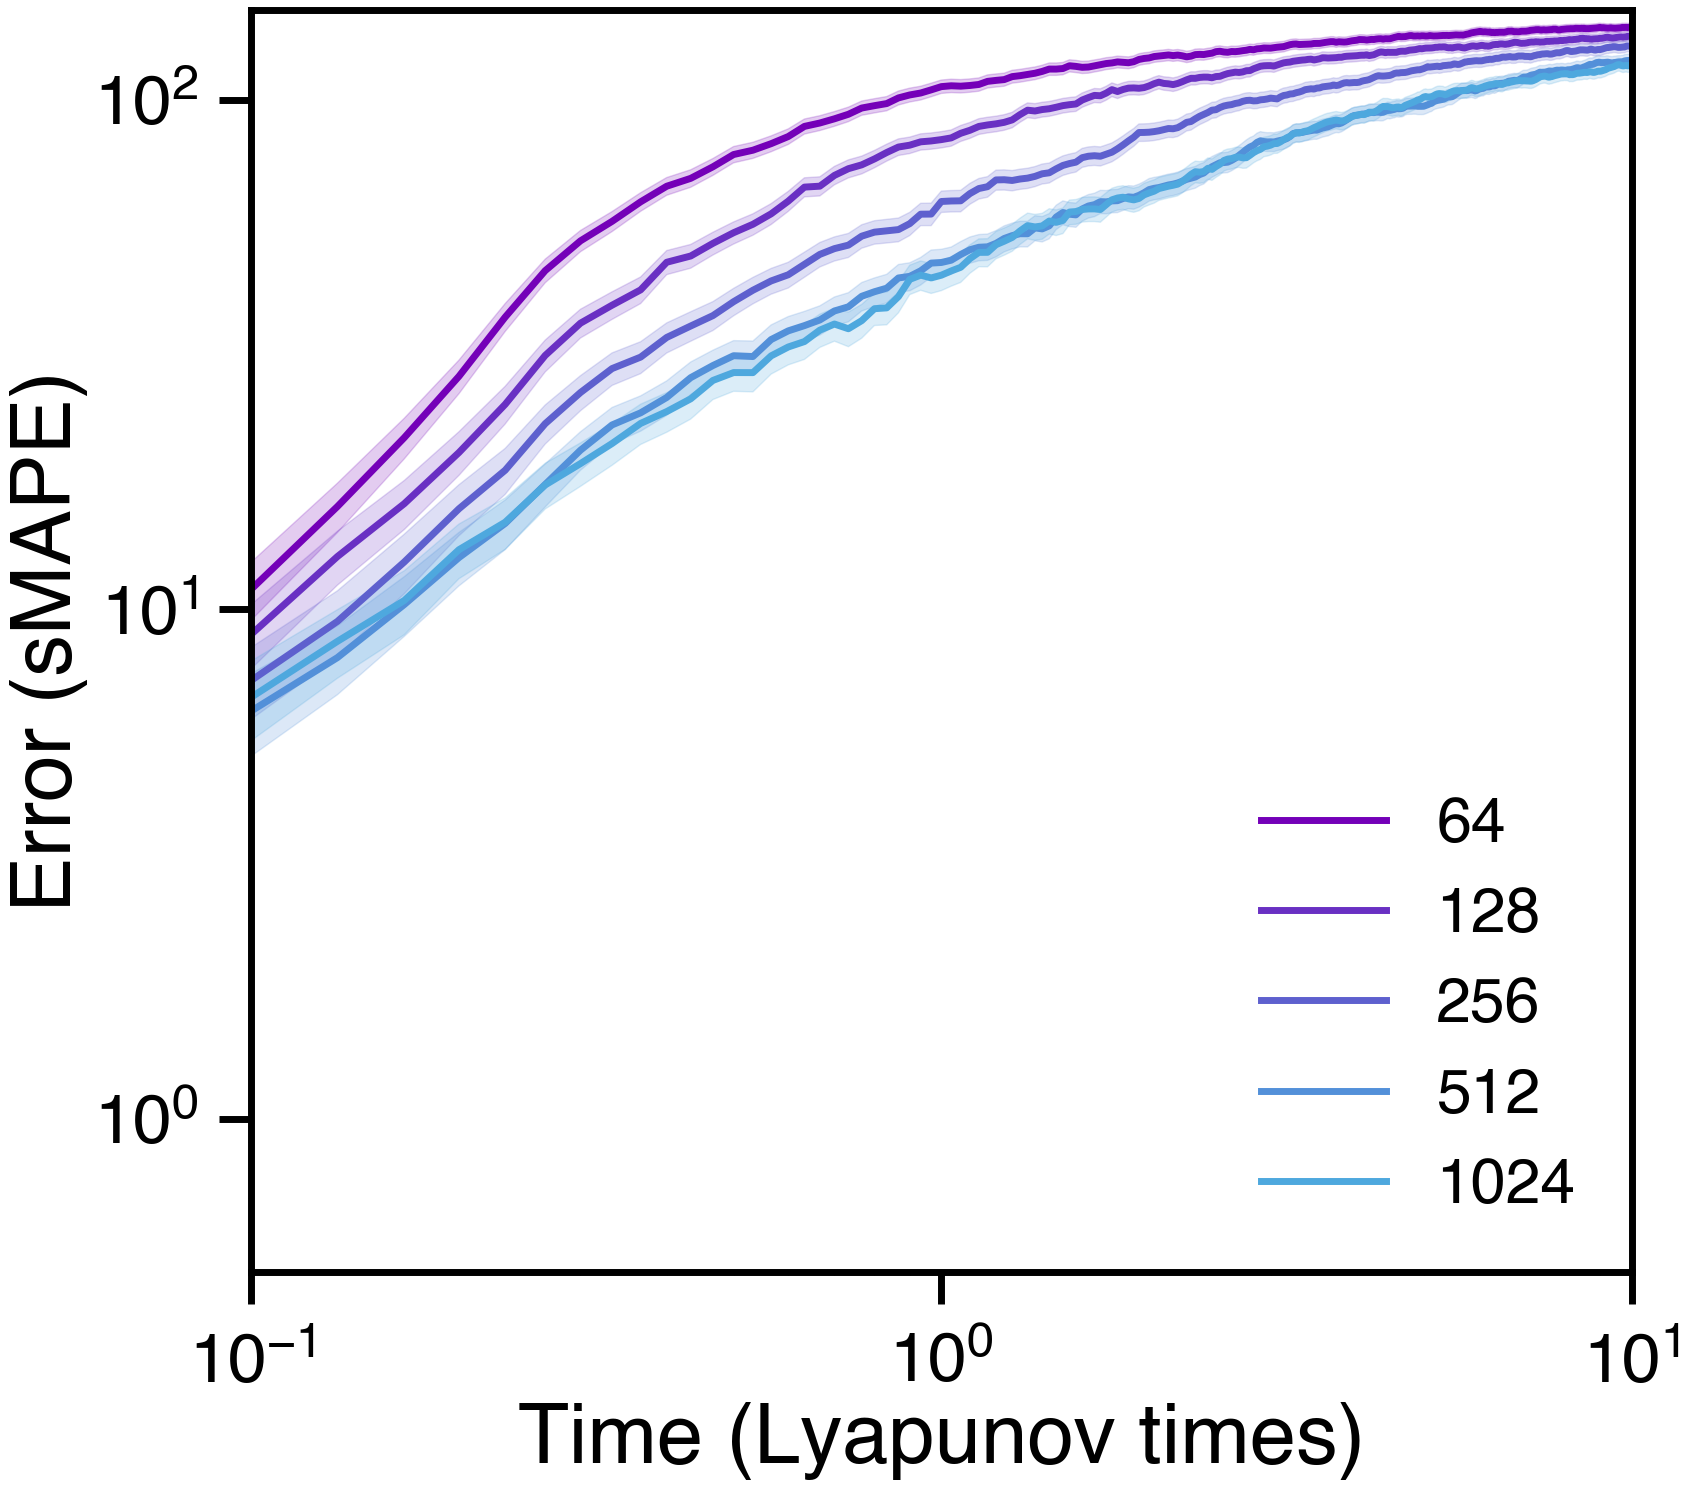

In [9]:
#import degas as dg
colors = ['#f94144', '#f3722c', '#f8961e', '#f9844a', '#f9c74f', '#90be6d', '#43aa8b', '#4d908e', '#577590', '#277da1']
colors = ["#7400b8","#6930c3","#5e60ce","#5390d9","#4ea8de","#48bfe3","#56cfe1","#64dfdf","#72efdd","#80ffdb"]

time = np.arange(1/granularity, (forecast_length+1)/granularity, 1/granularity)

# Plot Average VPT vs. Context Length for each equation
fig = plt.figure()
ax = fig.add_subplot(111)

for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(5)
for axis in ['top','right']:
  ax.spines[axis].set_linewidth(5)
  #ax.spines[axis].set_visible(False)

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

fig.set_size_inches(17,15)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)
plt.xlabel(r'Time (Lyapunov times)', fontname="Helvetica", fontsize = 60)
plt.ylabel(r'Error (sMAPE)', fontname="Helvetica", fontsize = 60)
  
for i, context_length in enumerate(context_lengths):
  smape_trjs = [median_smape[(equation_name, context_length)] for equation_name, ctx in median_smape.keys() if ctx == context_length]
  smape_trj = np.median(smape_trjs, axis=0)
  smape_std = np.std(smape_trjs, axis=0)/np.sqrt(len(equation_names))
  plt.plot(time, smape_trj, lw=5, ls='-', alpha=1, color=colors[i], label=context_length)
  ax.fill_between(time, smape_trj - smape_std, smape_trj + smape_std, alpha=0.2, color=colors[i])
  #dg.plot_err(smape_trj, smape_std/1.0, x=time, color=colors[i], label=context_length, zorder=10*i)

plt.xscale('log')
plt.yscale('log')

plt.xlim([.1, 10])
plt.ylim([.5, 150])

plt.legend(loc='lower right', frameon=False, prop={'size':45}, ncol=1)

plt.gca().tick_params(axis='y', pad=15, size=23, width=5)
plt.gca().tick_params(axis='x', pad=20, size=23, width=5)

fig.set_tight_layout(True)
#plt.savefig(f'smape_rolling_chronos.pdf', bbox_inches='tight')